In [ ]:
%load_ext autoreload
%autoreload 2

from datasets import load_dataset, load_metric
from transformers import (AutoModelForSequenceClassification, AutoTokenizer,
                          Trainer, TrainingArguments)

from models.hugging_face_vit import ViTForImageClassification, ViTConfig
from transformers import BertTokenizer, GPT2Tokenizer, ViTFeatureExtractor
from mup import set_base_shapes, make_base_shapes
import numpy as np
import torch
from functools import partial
from time import time
from ray import tune
import matplotlib.pyplot as plt

In [13]:
def make_bsh(filename=None):
    base_config = ViTConfig(
      hidden_size= 256,
      intermediate_size=256,
      num_attention_heads=4,
      activation_function='relu',
      num_hidden_layers=2,
      num_labels=3,
    )
    delta_config = ViTConfig(
      num_attention_heads=5,
      intermediate_size=200,
      hidden_size=200,
      activation_function='relu',
      num_hidden_layers=2,
      num_labels=3,
    )
    base_model = ViTForImageClassification(config=base_config)
    delta_model = ViTForImageClassification(config=delta_config)
    base_shapes = make_base_shapes(base_model, delta_model, savefile=filename)
    return base_shapes


In [14]:
model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

ds = load_dataset('beans')

def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

prepared_ds = ds.with_transform(transform)
labels = ds['train'].features['labels']

loading configuration file preprocessor_config.json from cache at /homes/isaacd/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/1ba429d32753f33a0660b80ac6f43a3c80c18938/preprocessor_config.json
Feature extractor ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}

Using custom data configuration default
Reusing dataset beans (/homes/isaacd/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791)


  0%|          | 0/3 [00:00<?, ?it/s]

In [15]:
def get_model(width, base_shape=None, mup=True, readout_zero_init=True, query_zero_init=True, vary_nhead=False, n_labels=3):
    width = int(width)
    nhead = 4
    if vary_nhead:
        nhead = int(4 * width / 252)
    def f():
        config = ViTConfig(
            hidden_size=width,
            num_labels=n_labels,
            intermediate_size=width,
            num_attention_heads=nhead,
            num_hidden_layers=2,
            attn_mult=8 if mup else None,
        )
        model = ViTForImageClassification(config=config)

        if mup:
          set_base_shapes(model, base_shape)
        else:
          set_base_shapes(model, None)

        model.apply(
          partial(model._init_weights,
                  readout_zero_init=readout_zero_init,
                  query_zero_init=query_zero_init,
                  ))
        return model
    return f

In [16]:
from mup.optim import MuAdamW

class MuTrainer(Trainer):
    def create_optimizer_and_scheduler(self, num_training_steps: int):
        """
        Setup the optimizer and the learning rate scheduler.

        We provide a reasonable default that works well. If you want to use something else, you can pass a tuple in the
        Trainer's init through `optimizers`, or subclass and override this method (or `create_optimizer` and/or
        `create_scheduler`) in a subclass.
        """
        
        self.optimizer = MuAdamW(self.model.parameters(), lr=5e-5)
        self.create_scheduler(num_training_steps=num_training_steps, optimizer=self.optimizer)

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

In [17]:
tune_config = {
    "learning_rate": tune.uniform(1e-3, 1e-7),
}

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
No `resources_per_trial` arg was passed into `hyperparameter_search`. Setting it to a default value of 1 CPU for each trial.


== Status ==
Current time: 2022-11-09 13:26:36 (running for 00:00:00.17)
Memory usage on this node: 33.9/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_mup_test_width_64
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+
| Trial name             | status   | loc                |   learning_rate |
|------------------------+----------+--------------------+-----------------|
| _objective_5ecb2_00000 | RUNNING  | 10.155.69.47:21117 |     0.000625497 |
| _objective_5ecb2_00001 | PENDING  |                    |     4.93808e-05 |
| _objective_5ecb2_00002 | PENDING  |                    |     0.000268079 |
| _objective_5ecb2_00003 | PENDING  |                    |     0.000401401 |
| _objective_5ecb2_00004 | PENDING  |                    |     0.000843997 |
| _objective_5ecb2_00005 | 

2022-11-09 13:28:30,772	INFO tune.py:759 -- Total run time: 114.88 seconds (114.76 seconds for the tuning loop).
No `resources_per_trial` arg was passed into `hyperparameter_search`. Setting it to a default value of 1 CPU for each trial.


Result for _objective_5ecb2_00009:
  date: 2022-11-09_13-28-30
  done: true
  epoch: 3.0
  eval_accuracy: 0.6390977443609023
  eval_loss: 0.8439836502075195
  eval_runtime: 1.1116
  eval_samples_per_second: 119.647
  eval_steps_per_second: 15.293
  experiment_id: e46e78ce9c974b5da6554e8a24c155cc
  hostname: ubumews11672
  iterations_since_restore: 1
  node_ip: 10.155.69.47
  objective: 0.6390977443609023
  pid: 24157
  time_since_restore: 48.30079913139343
  time_this_iter_s: 48.30079913139343
  time_total_s: 48.30079913139343
  timestamp: 1667993310
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5ecb2_00009
  warmup_time: 0.0054204463958740234
  
== Status ==
Current time: 2022-11-09 13:28:30 (running for 00:01:54.76)
Memory usage on this node: 33.9/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_mup_test_width_64
Number of trials: 

2022-11-09 13:30:49,178	INFO tune.py:759 -- Total run time: 138.35 seconds (138.23 seconds for the tuning loop).
No `resources_per_trial` arg was passed into `hyperparameter_search`. Setting it to a default value of 1 CPU for each trial.


Result for _objective_a34d0_00009:
  date: 2022-11-09_13-30-49
  done: true
  epoch: 3.0
  eval_accuracy: 0.6240601503759399
  eval_loss: 0.850283145904541
  eval_runtime: 1.2481
  eval_samples_per_second: 106.561
  eval_steps_per_second: 13.621
  experiment_id: 80fce597fc144ef3a5f73c946e2a5d99
  hostname: ubumews11672
  iterations_since_restore: 1
  node_ip: 10.155.69.47
  objective: 0.6240601503759399
  pid: 29427
  time_since_restore: 72.71432948112488
  time_this_iter_s: 72.71432948112488
  time_total_s: 72.71432948112488
  timestamp: 1667993449
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a34d0_00009
  warmup_time: 0.002874135971069336
  
== Status ==
Current time: 2022-11-09 13:30:49 (running for 00:02:18.24)
Memory usage on this node: 33.8/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_mup_test_width_128
Number of trials: 1

2022-11-09 13:34:22,891	INFO tune.py:759 -- Total run time: 213.64 seconds (213.52 seconds for the tuning loop).


Result for _objective_f5cee_00009:
  date: 2022-11-09_13-34-22
  done: true
  epoch: 3.0
  eval_accuracy: 0.631578947368421
  eval_loss: 0.8500210046768188
  eval_runtime: 1.5226
  eval_samples_per_second: 87.352
  eval_steps_per_second: 11.165
  experiment_id: 8c77225cf8624397aca2105f10123a73
  hostname: ubumews11672
  iterations_since_restore: 1
  node_ip: 10.155.69.47
  objective: 0.631578947368421
  pid: 3868
  time_since_restore: 126.06140923500061
  time_this_iter_s: 126.06140923500061
  time_total_s: 126.06140923500061
  timestamp: 1667993662
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f5cee_00009
  warmup_time: 0.005065202713012695
  
(_objective pid=3868) {'eval_loss': 0.8500210046768188, 'eval_accuracy': 0.631578947368421, 'eval_runtime': 1.5226, 'eval_samples_per_second': 87.352, 'eval_steps_per_second': 11.165, 'epoch': 3.0}
== Status ==
Current time: 2022-11-09 13:34:22 (running for 00:03:33.52)
Memory usage on this node: 33.9/62.5 GiB
Using FIFO sched

No `resources_per_trial` arg was passed into `hyperparameter_search`. Setting it to a default value of 1 CPU for each trial.


== Status ==
Current time: 2022-11-09 13:34:23 (running for 00:00:00.16)
Memory usage on this node: 33.5/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_mup_test_width_512
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+-------------------+-----------------+
| Trial name             | status   | loc               |   learning_rate |
|------------------------+----------+-------------------+-----------------|
| _objective_7537d_00000 | RUNNING  | 10.155.69.47:9321 |     0.000625497 |
| _objective_7537d_00001 | PENDING  |                   |     4.93808e-05 |
| _objective_7537d_00002 | PENDING  |                   |     0.000268079 |
| _objective_7537d_00003 | PENDING  |                   |     0.000401401 |
| _objective_7537d_00004 | PENDING  |                   |     0.000843997 |
| _objective_7537d_00005 | PENDING

2022-11-09 13:41:37,066	INFO tune.py:759 -- Total run time: 434.06 seconds (433.94 seconds for the tuning loop).


Result for _objective_7537d_00008:
  date: 2022-11-09_13-41-36
  done: true
  epoch: 3.0
  eval_accuracy: 0.6015037593984962
  eval_loss: 0.8746978640556335
  eval_runtime: 2.886
  eval_samples_per_second: 46.084
  eval_steps_per_second: 5.89
  experiment_id: 9310243eb6d64d668c0d81fb3c3f4cb4
  hostname: ubumews11672
  iterations_since_restore: 1
  node_ip: 10.155.69.47
  objective: 0.6015037593984962
  pid: 11916
  time_since_restore: 375.41374707221985
  time_this_iter_s: 375.41374707221985
  time_total_s: 375.41374707221985
  timestamp: 1667994096
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 7537d_00008
  warmup_time: 0.002958059310913086
  
== Status ==
Current time: 2022-11-09 13:41:36 (running for 00:07:13.94)
Memory usage on this node: 33.7/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_mup_test_width_512
Number of trials: 1

No `resources_per_trial` arg was passed into `hyperparameter_search`. Setting it to a default value of 1 CPU for each trial.


== Status ==
Current time: 2022-11-09 13:41:37 (running for 00:00:00.15)
Memory usage on this node: 33.6/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_mup_test_width_1024
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+
| Trial name             | status   | loc                |   learning_rate |
|------------------------+----------+--------------------+-----------------|
| _objective_78259_00000 | RUNNING  | 10.155.69.47:30436 |     0.000625497 |
| _objective_78259_00001 | PENDING  |                    |     4.93808e-05 |
| _objective_78259_00002 | PENDING  |                    |     0.000268079 |
| _objective_78259_00003 | PENDING  |                    |     0.000401401 |
| _objective_78259_00004 | PENDING  |                    |     0.000843997 |
| _objective_78259_00005 

2022-11-09 14:02:19,186	INFO tune.py:759 -- Total run time: 1241.77 seconds (1241.64 seconds for the tuning loop).


Result for _objective_78259_00009:
  date: 2022-11-09_14-02-19
  done: true
  epoch: 3.0
  eval_accuracy: 0.6090225563909775
  eval_loss: 0.8595118522644043
  eval_runtime: 7.616
  eval_samples_per_second: 17.463
  eval_steps_per_second: 2.232
  experiment_id: 621a991657cd46c78cb9200b5d990f7f
  hostname: ubumews11672
  iterations_since_restore: 1
  node_ip: 10.155.69.47
  objective: 0.6090225563909775
  pid: 891
  time_since_restore: 1169.2338347434998
  time_this_iter_s: 1169.2338347434998
  time_total_s: 1169.2338347434998
  timestamp: 1667995339
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '78259_00009'
  warmup_time: 0.0054683685302734375
  
== Status ==
Current time: 2022-11-09 14:02:19 (running for 00:20:41.65)
Memory usage on this node: 33.5/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_mup_test_width_1024
Number of trials

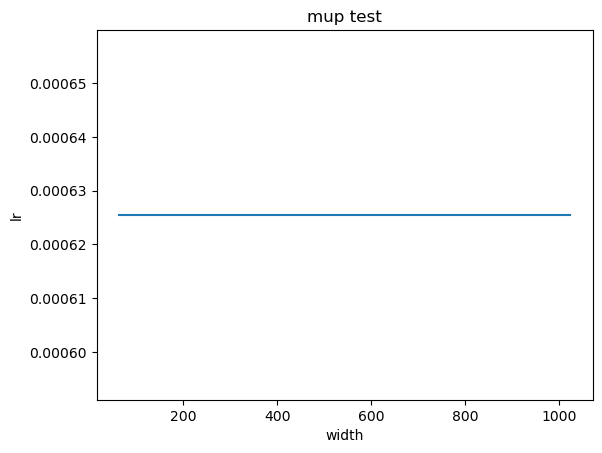

No `resources_per_trial` arg was passed into `hyperparameter_search`. Setting it to a default value of 1 CPU for each trial.


== Status ==
Current time: 2022-11-09 14:02:19 (running for 00:00:00.16)
Memory usage on this node: 33.5/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_64
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+
| Trial name             | status   | loc                |   learning_rate |
|------------------------+----------+--------------------+-----------------|
| _objective_5c607_00000 | RUNNING  | 10.155.69.47:17484 |     0.000625497 |
| _objective_5c607_00001 | PENDING  |                    |     4.93808e-05 |
| _objective_5c607_00002 | PENDING  |                    |     0.000268079 |
| _objective_5c607_00003 | PENDING  |                    |     0.000401401 |
| _objective_5c607_00004 | PENDING  |                    |     0.000843997 |
| _objective_5c607_00005 | P

(_objective pid=17484) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=17484)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:02:24 (running for 00:00:05.61)
Memory usage on this node: 33.7/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 2.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_64
Number of trials: 10/10 (8 PENDING, 2 RUNNING)
+------------------------+----------+--------------------+-----------------+
| Trial name             | status   | loc                |   learning_rate |
|------------------------+----------+--------------------+-----------------|
| _objective_5c607_00000 | RUNNING  | 10.155.69.47:17484 |     0.000625497 |
| _objective_5c607_00001 | RUNNING  | 10.155.69.47:17710 |     4.93808e-05 |
| _objective_5c607_00002 | PENDING  |                    |     0.000268079 |
| _objective_5c607_00003 | PENDING  |                    |     0.000401401 |
| _objective_5c607_00004 | PENDING  |                    |     0.000843997 |
| _objective_5c607_00005 | P

(_objective pid=17710) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=17710)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:02:30 (running for 00:00:10.89)
Memory usage on this node: 34.0/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_64
Number of trials: 10/10 (7 PENDING, 3 RUNNING)
+------------------------+----------+--------------------+-----------------+
| Trial name             | status   | loc                |   learning_rate |
|------------------------+----------+--------------------+-----------------|
| _objective_5c607_00000 | RUNNING  | 10.155.69.47:17484 |     0.000625497 |
| _objective_5c607_00001 | RUNNING  | 10.155.69.47:17710 |     4.93808e-05 |
| _objective_5c607_00002 | RUNNING  | 10.155.69.47:17952 |     0.000268079 |
| _objective_5c607_00003 | PENDING  |                    |     0.000401401 |
| _objective_5c607_00004 | PENDING  |                    |     0.000843997 |
| _objective_5c607_00005 | P

(_objective pid=17952) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=17952)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:02:35 (running for 00:00:16.30)
Memory usage on this node: 34.3/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_64
Number of trials: 10/10 (6 PENDING, 4 RUNNING)
+------------------------+----------+--------------------+-----------------+
| Trial name             | status   | loc                |   learning_rate |
|------------------------+----------+--------------------+-----------------|
| _objective_5c607_00000 | RUNNING  | 10.155.69.47:17484 |     0.000625497 |
| _objective_5c607_00001 | RUNNING  | 10.155.69.47:17710 |     4.93808e-05 |
| _objective_5c607_00002 | RUNNING  | 10.155.69.47:17952 |     0.000268079 |
| _objective_5c607_00003 | RUNNING  | 10.155.69.47:18264 |     0.000401401 |
| _objective_5c607_00004 | PENDING  |                    |     0.000843997 |
| _objective_5c607_00005 | P

(_objective pid=18264) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=18264)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:02:41 (running for 00:00:21.93)
Memory usage on this node: 34.6/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 5.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_64
Number of trials: 10/10 (5 PENDING, 5 RUNNING)
+------------------------+----------+--------------------+-----------------+
| Trial name             | status   | loc                |   learning_rate |
|------------------------+----------+--------------------+-----------------|
| _objective_5c607_00000 | RUNNING  | 10.155.69.47:17484 |     0.000625497 |
| _objective_5c607_00001 | RUNNING  | 10.155.69.47:17710 |     4.93808e-05 |
| _objective_5c607_00002 | RUNNING  | 10.155.69.47:17952 |     0.000268079 |
| _objective_5c607_00003 | RUNNING  | 10.155.69.47:18264 |     0.000401401 |
| _objective_5c607_00004 | RUNNING  | 10.155.69.47:18500 |     0.000843997 |
| _objective_5c607_00005 | P

(_objective pid=18500) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=18500)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:02:47 (running for 00:00:27.89)
Memory usage on this node: 34.9/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 6.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_64
Number of trials: 10/10 (4 PENDING, 6 RUNNING)
+------------------------+----------+--------------------+-----------------+
| Trial name             | status   | loc                |   learning_rate |
|------------------------+----------+--------------------+-----------------|
| _objective_5c607_00000 | RUNNING  | 10.155.69.47:17484 |     0.000625497 |
| _objective_5c607_00001 | RUNNING  | 10.155.69.47:17710 |     4.93808e-05 |
| _objective_5c607_00002 | RUNNING  | 10.155.69.47:17952 |     0.000268079 |
| _objective_5c607_00003 | RUNNING  | 10.155.69.47:18264 |     0.000401401 |
| _objective_5c607_00004 | RUNNING  | 10.155.69.47:18500 |     0.000843997 |
| _objective_5c607_00005 | R

(_objective pid=18705) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=18705)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:02:53 (running for 00:00:34.28)
Memory usage on this node: 35.2/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_64
Number of trials: 10/10 (3 PENDING, 7 RUNNING)
+------------------------+----------+--------------------+-----------------+
| Trial name             | status   | loc                |   learning_rate |
|------------------------+----------+--------------------+-----------------|
| _objective_5c607_00000 | RUNNING  | 10.155.69.47:17484 |     0.000625497 |
| _objective_5c607_00001 | RUNNING  | 10.155.69.47:17710 |     4.93808e-05 |
| _objective_5c607_00002 | RUNNING  | 10.155.69.47:17952 |     0.000268079 |
| _objective_5c607_00003 | RUNNING  | 10.155.69.47:18264 |     0.000401401 |
| _objective_5c607_00004 | RUNNING  | 10.155.69.47:18500 |     0.000843997 |
| _objective_5c607_00005 | R

(_objective pid=19003) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=19003)   FutureWarning,


(_objective pid=17484) {'train_runtime': 40.4154, 'train_samples_per_second': 76.753, 'train_steps_per_second': 9.65, 'train_loss': 0.910937265249399, 'epoch': 3.0}
== Status ==
Current time: 2022-11-09 14:03:00 (running for 00:00:40.90)
Memory usage on this node: 35.5/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_64
Number of trials: 10/10 (2 PENDING, 8 RUNNING)
+------------------------+----------+--------------------+-----------------+
| Trial name             | status   | loc                |   learning_rate |
|------------------------+----------+--------------------+-----------------|
| _objective_5c607_00000 | RUNNING  | 10.155.69.47:17484 |     0.000625497 |
| _objective_5c607_00001 | RUNNING  | 10.155.69.47:17710 |     4.93808e-05 |
| _objective_5c607_00002 | RUNNING  | 10.155.69.47:17952 |     0.000268079 |
| _objective_5c60

(_objective pid=19242) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=19242)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:03:07 (running for 00:00:47.92)
Memory usage on this node: 35.8/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 9.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_64
Number of trials: 10/10 (1 PENDING, 9 RUNNING)
+------------------------+----------+--------------------+-----------------+
| Trial name             | status   | loc                |   learning_rate |
|------------------------+----------+--------------------+-----------------|
| _objective_5c607_00000 | RUNNING  | 10.155.69.47:17484 |     0.000625497 |
| _objective_5c607_00001 | RUNNING  | 10.155.69.47:17710 |     4.93808e-05 |
| _objective_5c607_00002 | RUNNING  | 10.155.69.47:17952 |     0.000268079 |
| _objective_5c607_00003 | RUNNING  | 10.155.69.47:18264 |     0.000401401 |
| _objective_5c607_00004 | RUNNING  | 10.155.69.47:18500 |     0.000843997 |
| _objective_5c607_00005 | R

(_objective pid=19734) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=19734)   FutureWarning,


(_objective pid=17710) {'train_runtime': 46.7088, 'train_samples_per_second': 66.412, 'train_steps_per_second': 8.35, 'train_loss': 1.0164725279196716, 'epoch': 3.0}
(_objective pid=17710) {'eval_loss': 0.9654121398925781, 'eval_accuracy': 0.6015037593984962, 'eval_runtime': 1.87, 'eval_samples_per_second': 71.124, 'eval_steps_per_second': 9.091, 'epoch': 3.0}
== Status ==
Current time: 2022-11-09 14:03:14 (running for 00:00:54.77)
Memory usage on this node: 36.1/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 10.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_64
Number of trials: 10/10 (10 RUNNING)
+------------------------+----------+--------------------+-----------------+
| Trial name             | status   | loc                |   learning_rate |
|------------------------+----------+--------------------+-----------------|
| _objective_5c607_00000 | RUNNING  | 10.155.69.47:17484 | 

(_objective pid=20161) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=20161)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:03:26 (running for 00:01:07.13)
Memory usage on this node: 35.9/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_64
Number of trials: 10/10 (8 RUNNING, 2 TERMINATED)
+------------------------+------------+--------------------+-----------------+-------------+
| Trial name             | status     | loc                |   learning_rate |   objective |
|------------------------+------------+--------------------+-----------------+-------------|
| _objective_5c607_00002 | RUNNING    | 10.155.69.47:17952 |     0.000268079 |             |
| _objective_5c607_00003 | RUNNING    | 10.155.69.47:18264 |     0.000401401 |             |
| _objective_5c607_00004 | RUNNING    | 10.155.69.47:18500 |     0.000843997 |             |
| _objective_5c607_00005 | RUNNING    | 10.155.69.47:18705 |     0.000844021 |     

2022-11-09 14:04:09,914	INFO tune.py:759 -- Total run time: 110.60 seconds (110.47 seconds for the tuning loop).
No `resources_per_trial` arg was passed into `hyperparameter_search`. Setting it to a default value of 1 CPU for each trial.


Result for _objective_5c607_00009:
  date: 2022-11-09_14-04-09
  done: true
  epoch: 3.0
  eval_accuracy: 0.5864661654135338
  eval_loss: 0.8596600890159607
  eval_runtime: 1.0677
  eval_samples_per_second: 124.564
  eval_steps_per_second: 15.922
  experiment_id: f1ed838d78b24f75909504b45cec340e
  hostname: ubumews11672
  iterations_since_restore: 1
  node_ip: 10.155.69.47
  objective: 0.5864661654135338
  pid: 20161
  time_since_restore: 48.379592180252075
  time_this_iter_s: 48.379592180252075
  time_total_s: 48.379592180252075
  timestamp: 1667995449
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5c607_00009
  warmup_time: 0.0022547245025634766
  
== Status ==
Current time: 2022-11-09 14:04:09 (running for 00:01:50.48)
Memory usage on this node: 33.6/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_64
Number of trials

(_objective pid=22630) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=22630)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:04:15 (running for 00:00:05.49)
Memory usage on this node: 33.7/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 2.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_128
Number of trials: 10/10 (8 PENDING, 2 RUNNING)
+------------------------+----------+--------------------+-----------------+
| Trial name             | status   | loc                |   learning_rate |
|------------------------+----------+--------------------+-----------------|
| _objective_9e543_00000 | RUNNING  | 10.155.69.47:22630 |     0.000625497 |
| _objective_9e543_00001 | RUNNING  | 10.155.69.47:22856 |     4.93808e-05 |
| _objective_9e543_00002 | PENDING  |                    |     0.000268079 |
| _objective_9e543_00003 | PENDING  |                    |     0.000401401 |
| _objective_9e543_00004 | PENDING  |                    |     0.000843997 |
| _objective_9e543_00005 | 

(_objective pid=22856) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=22856)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:04:20 (running for 00:00:10.86)
Memory usage on this node: 34.1/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_128
Number of trials: 10/10 (7 PENDING, 3 RUNNING)
+------------------------+----------+--------------------+-----------------+
| Trial name             | status   | loc                |   learning_rate |
|------------------------+----------+--------------------+-----------------|
| _objective_9e543_00000 | RUNNING  | 10.155.69.47:22630 |     0.000625497 |
| _objective_9e543_00001 | RUNNING  | 10.155.69.47:22856 |     4.93808e-05 |
| _objective_9e543_00002 | RUNNING  | 10.155.69.47:23065 |     0.000268079 |
| _objective_9e543_00003 | PENDING  |                    |     0.000401401 |
| _objective_9e543_00004 | PENDING  |                    |     0.000843997 |
| _objective_9e543_00005 | 

(_objective pid=23065) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=23065)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:04:26 (running for 00:00:16.24)
Memory usage on this node: 34.4/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_128
Number of trials: 10/10 (6 PENDING, 4 RUNNING)
+------------------------+----------+--------------------+-----------------+
| Trial name             | status   | loc                |   learning_rate |
|------------------------+----------+--------------------+-----------------|
| _objective_9e543_00000 | RUNNING  | 10.155.69.47:22630 |     0.000625497 |
| _objective_9e543_00001 | RUNNING  | 10.155.69.47:22856 |     4.93808e-05 |
| _objective_9e543_00002 | RUNNING  | 10.155.69.47:23065 |     0.000268079 |
| _objective_9e543_00003 | RUNNING  | 10.155.69.47:23426 |     0.000401401 |
| _objective_9e543_00004 | PENDING  |                    |     0.000843997 |
| _objective_9e543_00005 | 

(_objective pid=23426) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=23426)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:04:31 (running for 00:00:21.83)
Memory usage on this node: 34.8/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 5.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_128
Number of trials: 10/10 (5 PENDING, 5 RUNNING)
+------------------------+----------+--------------------+-----------------+
| Trial name             | status   | loc                |   learning_rate |
|------------------------+----------+--------------------+-----------------|
| _objective_9e543_00000 | RUNNING  | 10.155.69.47:22630 |     0.000625497 |
| _objective_9e543_00001 | RUNNING  | 10.155.69.47:22856 |     4.93808e-05 |
| _objective_9e543_00002 | RUNNING  | 10.155.69.47:23065 |     0.000268079 |
| _objective_9e543_00003 | RUNNING  | 10.155.69.47:23426 |     0.000401401 |
| _objective_9e543_00004 | RUNNING  | 10.155.69.47:23665 |     0.000843997 |
| _objective_9e543_00005 | 

(_objective pid=23665) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=23665)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:04:37 (running for 00:00:27.63)
Memory usage on this node: 35.1/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 6.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_128
Number of trials: 10/10 (4 PENDING, 6 RUNNING)
+------------------------+----------+--------------------+-----------------+
| Trial name             | status   | loc                |   learning_rate |
|------------------------+----------+--------------------+-----------------|
| _objective_9e543_00000 | RUNNING  | 10.155.69.47:22630 |     0.000625497 |
| _objective_9e543_00001 | RUNNING  | 10.155.69.47:22856 |     4.93808e-05 |
| _objective_9e543_00002 | RUNNING  | 10.155.69.47:23065 |     0.000268079 |
| _objective_9e543_00003 | RUNNING  | 10.155.69.47:23426 |     0.000401401 |
| _objective_9e543_00004 | RUNNING  | 10.155.69.47:23665 |     0.000843997 |
| _objective_9e543_00005 | 

(_objective pid=23889) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=23889)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:04:44 (running for 00:00:34.27)
Memory usage on this node: 35.3/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_128
Number of trials: 10/10 (3 PENDING, 7 RUNNING)
+------------------------+----------+--------------------+-----------------+
| Trial name             | status   | loc                |   learning_rate |
|------------------------+----------+--------------------+-----------------|
| _objective_9e543_00000 | RUNNING  | 10.155.69.47:22630 |     0.000625497 |
| _objective_9e543_00001 | RUNNING  | 10.155.69.47:22856 |     4.93808e-05 |
| _objective_9e543_00002 | RUNNING  | 10.155.69.47:23065 |     0.000268079 |
| _objective_9e543_00003 | RUNNING  | 10.155.69.47:23426 |     0.000401401 |
| _objective_9e543_00004 | RUNNING  | 10.155.69.47:23665 |     0.000843997 |
| _objective_9e543_00005 | 

(_objective pid=24229) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=24229)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:04:51 (running for 00:00:41.17)
Memory usage on this node: 35.7/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_128
Number of trials: 10/10 (2 PENDING, 8 RUNNING)
+------------------------+----------+--------------------+-----------------+
| Trial name             | status   | loc                |   learning_rate |
|------------------------+----------+--------------------+-----------------|
| _objective_9e543_00000 | RUNNING  | 10.155.69.47:22630 |     0.000625497 |
| _objective_9e543_00001 | RUNNING  | 10.155.69.47:22856 |     4.93808e-05 |
| _objective_9e543_00002 | RUNNING  | 10.155.69.47:23065 |     0.000268079 |
| _objective_9e543_00003 | RUNNING  | 10.155.69.47:23426 |     0.000401401 |
| _objective_9e543_00004 | RUNNING  | 10.155.69.47:23665 |     0.000843997 |
| _objective_9e543_00005 | 

(_objective pid=24571) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=24571)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:04:58 (running for 00:00:48.19)
Memory usage on this node: 36.0/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 9.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_128
Number of trials: 10/10 (1 PENDING, 9 RUNNING)
+------------------------+----------+--------------------+-----------------+
| Trial name             | status   | loc                |   learning_rate |
|------------------------+----------+--------------------+-----------------|
| _objective_9e543_00000 | RUNNING  | 10.155.69.47:22630 |     0.000625497 |
| _objective_9e543_00001 | RUNNING  | 10.155.69.47:22856 |     4.93808e-05 |
| _objective_9e543_00002 | RUNNING  | 10.155.69.47:23065 |     0.000268079 |
| _objective_9e543_00003 | RUNNING  | 10.155.69.47:23426 |     0.000401401 |
| _objective_9e543_00004 | RUNNING  | 10.155.69.47:23665 |     0.000843997 |
| _objective_9e543_00005 | 

(_objective pid=24856) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=24856)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:05:05 (running for 00:00:55.80)
Memory usage on this node: 36.4/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 10.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_128
Number of trials: 10/10 (10 RUNNING)
+------------------------+----------+--------------------+-----------------+
| Trial name             | status   | loc                |   learning_rate |
|------------------------+----------+--------------------+-----------------|
| _objective_9e543_00000 | RUNNING  | 10.155.69.47:22630 |     0.000625497 |
| _objective_9e543_00001 | RUNNING  | 10.155.69.47:22856 |     4.93808e-05 |
| _objective_9e543_00002 | RUNNING  | 10.155.69.47:23065 |     0.000268079 |
| _objective_9e543_00003 | RUNNING  | 10.155.69.47:23426 |     0.000401401 |
| _objective_9e543_00004 | RUNNING  | 10.155.69.47:23665 |     0.000843997 |
| _objective_9e543_00005 | RUNNING  

(_objective pid=25511) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=25511)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:05:19 (running for 00:01:09.13)
Memory usage on this node: 36.7/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 10.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_128
Number of trials: 10/10 (10 RUNNING)
+------------------------+----------+--------------------+-----------------+
| Trial name             | status   | loc                |   learning_rate |
|------------------------+----------+--------------------+-----------------|
| _objective_9e543_00000 | RUNNING  | 10.155.69.47:22630 |     0.000625497 |
| _objective_9e543_00001 | RUNNING  | 10.155.69.47:22856 |     4.93808e-05 |
| _objective_9e543_00002 | RUNNING  | 10.155.69.47:23065 |     0.000268079 |
| _objective_9e543_00003 | RUNNING  | 10.155.69.47:23426 |     0.000401401 |
| _objective_9e543_00004 | RUNNING  | 10.155.69.47:23665 |     0.000843997 |
| _objective_9e543_00005 | RUNNING  

2022-11-09 14:06:26,928	INFO tune.py:759 -- Total run time: 136.96 seconds (136.84 seconds for the tuning loop).
No `resources_per_trial` arg was passed into `hyperparameter_search`. Setting it to a default value of 1 CPU for each trial.


Result for _objective_9e543_00009:
  date: 2022-11-09_14-06-26
  done: true
  epoch: 3.0
  eval_accuracy: 0.6541353383458647
  eval_loss: 0.8220879435539246
  eval_runtime: 1.215
  eval_samples_per_second: 109.461
  eval_steps_per_second: 13.991
  experiment_id: 0d444a7702534423b4ebc4f8b9c9fd58
  hostname: ubumews11672
  iterations_since_restore: 1
  node_ip: 10.155.69.47
  objective: 0.6541353383458647
  pid: 25511
  time_since_restore: 72.70647978782654
  time_this_iter_s: 72.70647978782654
  time_total_s: 72.70647978782654
  timestamp: 1667995586
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9e543_00009
  warmup_time: 0.0034399032592773438
  
== Status ==
Current time: 2022-11-09 14:06:26 (running for 00:02:16.84)
Memory usage on this node: 33.7/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_128
Number of trials: 1

(_objective pid=28957) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=28957)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:06:33 (running for 00:00:06.31)
Memory usage on this node: 33.7/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 2.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_256
Number of trials: 10/10 (8 PENDING, 2 RUNNING)
+------------------------+----------+--------------------+-----------------+
| Trial name             | status   | loc                |   learning_rate |
|------------------------+----------+--------------------+-----------------|
| _objective_f0025_00000 | RUNNING  | 10.155.69.47:28957 |     0.000625497 |
| _objective_f0025_00001 | RUNNING  | 10.155.69.47:29212 |     4.93808e-05 |
| _objective_f0025_00002 | PENDING  |                    |     0.000268079 |
| _objective_f0025_00003 | PENDING  |                    |     0.000401401 |
| _objective_f0025_00004 | PENDING  |                    |     0.000843997 |
| _objective_f0025_00005 | 

(_objective pid=29212) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=29212)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:06:38 (running for 00:00:11.93)
Memory usage on this node: 34.1/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_256
Number of trials: 10/10 (7 PENDING, 3 RUNNING)
+------------------------+----------+--------------------+-----------------+
| Trial name             | status   | loc                |   learning_rate |
|------------------------+----------+--------------------+-----------------|
| _objective_f0025_00000 | RUNNING  | 10.155.69.47:28957 |     0.000625497 |
| _objective_f0025_00001 | RUNNING  | 10.155.69.47:29212 |     4.93808e-05 |
| _objective_f0025_00002 | RUNNING  | 10.155.69.47:29563 |     0.000268079 |
| _objective_f0025_00003 | PENDING  |                    |     0.000401401 |
| _objective_f0025_00004 | PENDING  |                    |     0.000843997 |
| _objective_f0025_00005 | 

(_objective pid=29563) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=29563)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:06:44 (running for 00:00:17.43)
Memory usage on this node: 34.3/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_256
Number of trials: 10/10 (6 PENDING, 4 RUNNING)
+------------------------+----------+--------------------+-----------------+
| Trial name             | status   | loc                |   learning_rate |
|------------------------+----------+--------------------+-----------------|
| _objective_f0025_00000 | RUNNING  | 10.155.69.47:28957 |     0.000625497 |
| _objective_f0025_00001 | RUNNING  | 10.155.69.47:29212 |     4.93808e-05 |
| _objective_f0025_00002 | RUNNING  | 10.155.69.47:29563 |     0.000268079 |
| _objective_f0025_00003 | RUNNING  | 10.155.69.47:29772 |     0.000401401 |
| _objective_f0025_00004 | PENDING  |                    |     0.000843997 |
| _objective_f0025_00005 | 

(_objective pid=29772) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=29772)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:06:50 (running for 00:00:23.20)
Memory usage on this node: 34.7/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 5.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_256
Number of trials: 10/10 (5 PENDING, 5 RUNNING)
+------------------------+----------+--------------------+-----------------+
| Trial name             | status   | loc                |   learning_rate |
|------------------------+----------+--------------------+-----------------|
| _objective_f0025_00000 | RUNNING  | 10.155.69.47:28957 |     0.000625497 |
| _objective_f0025_00001 | RUNNING  | 10.155.69.47:29212 |     4.93808e-05 |
| _objective_f0025_00002 | RUNNING  | 10.155.69.47:29563 |     0.000268079 |
| _objective_f0025_00003 | RUNNING  | 10.155.69.47:29772 |     0.000401401 |
| _objective_f0025_00004 | RUNNING  | 10.155.69.47:29977 |     0.000843997 |
| _objective_f0025_00005 | 

(_objective pid=29977) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=29977)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:06:56 (running for 00:00:29.68)
Memory usage on this node: 35.0/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 6.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_256
Number of trials: 10/10 (4 PENDING, 6 RUNNING)
+------------------------+----------+--------------------+-----------------+
| Trial name             | status   | loc                |   learning_rate |
|------------------------+----------+--------------------+-----------------|
| _objective_f0025_00000 | RUNNING  | 10.155.69.47:28957 |     0.000625497 |
| _objective_f0025_00001 | RUNNING  | 10.155.69.47:29212 |     4.93808e-05 |
| _objective_f0025_00002 | RUNNING  | 10.155.69.47:29563 |     0.000268079 |
| _objective_f0025_00003 | RUNNING  | 10.155.69.47:29772 |     0.000401401 |
| _objective_f0025_00004 | RUNNING  | 10.155.69.47:29977 |     0.000843997 |
| _objective_f0025_00005 | 

(_objective pid=30191) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=30191)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:07:04 (running for 00:00:37.93)
Memory usage on this node: 35.4/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_256
Number of trials: 10/10 (3 PENDING, 7 RUNNING)
+------------------------+----------+--------------------+-----------------+
| Trial name             | status   | loc                |   learning_rate |
|------------------------+----------+--------------------+-----------------|
| _objective_f0025_00000 | RUNNING  | 10.155.69.47:28957 |     0.000625497 |
| _objective_f0025_00001 | RUNNING  | 10.155.69.47:29212 |     4.93808e-05 |
| _objective_f0025_00002 | RUNNING  | 10.155.69.47:29563 |     0.000268079 |
| _objective_f0025_00003 | RUNNING  | 10.155.69.47:29772 |     0.000401401 |
| _objective_f0025_00004 | RUNNING  | 10.155.69.47:29977 |     0.000843997 |
| _objective_f0025_00005 | 

(_objective pid=30693) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=30693)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:07:12 (running for 00:00:45.49)
Memory usage on this node: 35.7/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_256
Number of trials: 10/10 (2 PENDING, 8 RUNNING)
+------------------------+----------+--------------------+-----------------+
| Trial name             | status   | loc                |   learning_rate |
|------------------------+----------+--------------------+-----------------|
| _objective_f0025_00000 | RUNNING  | 10.155.69.47:28957 |     0.000625497 |
| _objective_f0025_00001 | RUNNING  | 10.155.69.47:29212 |     4.93808e-05 |
| _objective_f0025_00002 | RUNNING  | 10.155.69.47:29563 |     0.000268079 |
| _objective_f0025_00003 | RUNNING  | 10.155.69.47:29772 |     0.000401401 |
| _objective_f0025_00004 | RUNNING  | 10.155.69.47:29977 |     0.000843997 |
| _objective_f0025_00005 | 

(_objective pid=30957) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=30957)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:07:19 (running for 00:00:52.94)
Memory usage on this node: 36.1/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 9.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_256
Number of trials: 10/10 (1 PENDING, 9 RUNNING)
+------------------------+----------+--------------------+-----------------+
| Trial name             | status   | loc                |   learning_rate |
|------------------------+----------+--------------------+-----------------|
| _objective_f0025_00000 | RUNNING  | 10.155.69.47:28957 |     0.000625497 |
| _objective_f0025_00001 | RUNNING  | 10.155.69.47:29212 |     4.93808e-05 |
| _objective_f0025_00002 | RUNNING  | 10.155.69.47:29563 |     0.000268079 |
| _objective_f0025_00003 | RUNNING  | 10.155.69.47:29772 |     0.000401401 |
| _objective_f0025_00004 | RUNNING  | 10.155.69.47:29977 |     0.000843997 |
| _objective_f0025_00005 | 

(_objective pid=31337) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=31337)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:07:27 (running for 00:01:00.95)
Memory usage on this node: 36.4/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 10.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_256
Number of trials: 10/10 (10 RUNNING)
+------------------------+----------+--------------------+-----------------+
| Trial name             | status   | loc                |   learning_rate |
|------------------------+----------+--------------------+-----------------|
| _objective_f0025_00000 | RUNNING  | 10.155.69.47:28957 |     0.000625497 |
| _objective_f0025_00001 | RUNNING  | 10.155.69.47:29212 |     4.93808e-05 |
| _objective_f0025_00002 | RUNNING  | 10.155.69.47:29563 |     0.000268079 |
| _objective_f0025_00003 | RUNNING  | 10.155.69.47:29772 |     0.000401401 |
| _objective_f0025_00004 | RUNNING  | 10.155.69.47:29977 |     0.000843997 |
| _objective_f0025_00005 | RUNNING  

(_objective pid=31566) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=31566)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:07:41 (running for 00:01:14.72)
Memory usage on this node: 36.9/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 10.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_256
Number of trials: 10/10 (10 RUNNING)
+------------------------+----------+--------------------+-----------------+
| Trial name             | status   | loc                |   learning_rate |
|------------------------+----------+--------------------+-----------------|
| _objective_f0025_00000 | RUNNING  | 10.155.69.47:28957 |     0.000625497 |
| _objective_f0025_00001 | RUNNING  | 10.155.69.47:29212 |     4.93808e-05 |
| _objective_f0025_00002 | RUNNING  | 10.155.69.47:29563 |     0.000268079 |
| _objective_f0025_00003 | RUNNING  | 10.155.69.47:29772 |     0.000401401 |
| _objective_f0025_00004 | RUNNING  | 10.155.69.47:29977 |     0.000843997 |
| _objective_f0025_00005 | RUNNING  

2022-11-09 14:09:53,941	INFO tune.py:759 -- Total run time: 206.94 seconds (206.81 seconds for the tuning loop).


Result for _objective_f0025_00009:
  date: 2022-11-09_14-09-53
  done: true
  epoch: 3.0
  eval_accuracy: 0.6917293233082706
  eval_loss: 0.7255355715751648
  eval_runtime: 1.5383
  eval_samples_per_second: 86.457
  eval_steps_per_second: 11.051
  experiment_id: af03a9beda4947ef8cd3325dc674e341
  hostname: ubumews11672
  iterations_since_restore: 1
  node_ip: 10.155.69.47
  objective: 0.6917293233082706
  pid: 31566
  time_since_restore: 137.09540677070618
  time_this_iter_s: 137.09540677070618
  time_total_s: 137.09540677070618
  timestamp: 1667995793
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f0025_00009
  warmup_time: 0.003347635269165039
  
== Status ==
Current time: 2022-11-09 14:09:53 (running for 00:03:26.81)
Memory usage on this node: 33.5/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_256
Number of trials:

No `resources_per_trial` arg was passed into `hyperparameter_search`. Setting it to a default value of 1 CPU for each trial.


== Status ==
Current time: 2022-11-09 14:09:54 (running for 00:00:00.18)
Memory usage on this node: 33.4/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_512
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+-------------------+-----------------+
| Trial name             | status   | loc               |   learning_rate |
|------------------------+----------+-------------------+-----------------|
| _objective_6b6f8_00000 | RUNNING  | 10.155.69.47:5332 |     0.000625497 |
| _objective_6b6f8_00001 | PENDING  |                   |     4.93808e-05 |
| _objective_6b6f8_00002 | PENDING  |                   |     0.000268079 |
| _objective_6b6f8_00003 | PENDING  |                   |     0.000401401 |
| _objective_6b6f8_00004 | PENDING  |                   |     0.000843997 |
| _objective_6b6f8_00005 | PENDING 

(_objective pid=5332) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=5332)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:09:59 (running for 00:00:05.60)
Memory usage on this node: 33.6/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 2.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_512
Number of trials: 10/10 (8 PENDING, 2 RUNNING)
+------------------------+----------+-------------------+-----------------+
| Trial name             | status   | loc               |   learning_rate |
|------------------------+----------+-------------------+-----------------|
| _objective_6b6f8_00000 | RUNNING  | 10.155.69.47:5332 |     0.000625497 |
| _objective_6b6f8_00001 | RUNNING  | 10.155.69.47:5609 |     4.93808e-05 |
| _objective_6b6f8_00002 | PENDING  |                   |     0.000268079 |
| _objective_6b6f8_00003 | PENDING  |                   |     0.000401401 |
| _objective_6b6f8_00004 | PENDING  |                   |     0.000843997 |
| _objective_6b6f8_00005 | PENDING 

(_objective pid=5609) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=5609)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:10:05 (running for 00:00:11.54)
Memory usage on this node: 34.0/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_512
Number of trials: 10/10 (7 PENDING, 3 RUNNING)
+------------------------+----------+-------------------+-----------------+
| Trial name             | status   | loc               |   learning_rate |
|------------------------+----------+-------------------+-----------------|
| _objective_6b6f8_00000 | RUNNING  | 10.155.69.47:5332 |     0.000625497 |
| _objective_6b6f8_00001 | RUNNING  | 10.155.69.47:5609 |     4.93808e-05 |
| _objective_6b6f8_00002 | RUNNING  | 10.155.69.47:6006 |     0.000268079 |
| _objective_6b6f8_00003 | PENDING  |                   |     0.000401401 |
| _objective_6b6f8_00004 | PENDING  |                   |     0.000843997 |
| _objective_6b6f8_00005 | PENDING 

(_objective pid=6006) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=6006)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:10:11 (running for 00:00:17.30)
Memory usage on this node: 34.5/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_512
Number of trials: 10/10 (6 PENDING, 4 RUNNING)
+------------------------+----------+-------------------+-----------------+
| Trial name             | status   | loc               |   learning_rate |
|------------------------+----------+-------------------+-----------------|
| _objective_6b6f8_00000 | RUNNING  | 10.155.69.47:5332 |     0.000625497 |
| _objective_6b6f8_00001 | RUNNING  | 10.155.69.47:5609 |     4.93808e-05 |
| _objective_6b6f8_00002 | RUNNING  | 10.155.69.47:6006 |     0.000268079 |
| _objective_6b6f8_00003 | RUNNING  | 10.155.69.47:6225 |     0.000401401 |
| _objective_6b6f8_00004 | PENDING  |                   |     0.000843997 |
| _objective_6b6f8_00005 | PENDING 

(_objective pid=6225) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=6225)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:10:17 (running for 00:00:23.09)
Memory usage on this node: 34.9/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 5.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_512
Number of trials: 10/10 (5 PENDING, 5 RUNNING)
+------------------------+----------+-------------------+-----------------+
| Trial name             | status   | loc               |   learning_rate |
|------------------------+----------+-------------------+-----------------|
| _objective_6b6f8_00000 | RUNNING  | 10.155.69.47:5332 |     0.000625497 |
| _objective_6b6f8_00001 | RUNNING  | 10.155.69.47:5609 |     4.93808e-05 |
| _objective_6b6f8_00002 | RUNNING  | 10.155.69.47:6006 |     0.000268079 |
| _objective_6b6f8_00003 | RUNNING  | 10.155.69.47:6225 |     0.000401401 |
| _objective_6b6f8_00004 | RUNNING  | 10.155.69.47:6545 |     0.000843997 |
| _objective_6b6f8_00005 | PENDING 

(_objective pid=6545) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=6545)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:10:23 (running for 00:00:29.08)
Memory usage on this node: 35.3/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 6.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_512
Number of trials: 10/10 (4 PENDING, 6 RUNNING)
+------------------------+----------+-------------------+-----------------+
| Trial name             | status   | loc               |   learning_rate |
|------------------------+----------+-------------------+-----------------|
| _objective_6b6f8_00000 | RUNNING  | 10.155.69.47:5332 |     0.000625497 |
| _objective_6b6f8_00001 | RUNNING  | 10.155.69.47:5609 |     4.93808e-05 |
| _objective_6b6f8_00002 | RUNNING  | 10.155.69.47:6006 |     0.000268079 |
| _objective_6b6f8_00003 | RUNNING  | 10.155.69.47:6225 |     0.000401401 |
| _objective_6b6f8_00004 | RUNNING  | 10.155.69.47:6545 |     0.000843997 |
| _objective_6b6f8_00005 | RUNNING 

(_objective pid=6804) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=6804)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:10:29 (running for 00:00:35.88)
Memory usage on this node: 35.6/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_512
Number of trials: 10/10 (3 PENDING, 7 RUNNING)
+------------------------+----------+-------------------+-----------------+
| Trial name             | status   | loc               |   learning_rate |
|------------------------+----------+-------------------+-----------------|
| _objective_6b6f8_00000 | RUNNING  | 10.155.69.47:5332 |     0.000625497 |
| _objective_6b6f8_00001 | RUNNING  | 10.155.69.47:5609 |     4.93808e-05 |
| _objective_6b6f8_00002 | RUNNING  | 10.155.69.47:6006 |     0.000268079 |
| _objective_6b6f8_00003 | RUNNING  | 10.155.69.47:6225 |     0.000401401 |
| _objective_6b6f8_00004 | RUNNING  | 10.155.69.47:6545 |     0.000843997 |
| _objective_6b6f8_00005 | RUNNING 

(_objective pid=7236) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=7236)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:10:38 (running for 00:00:43.98)
Memory usage on this node: 36.2/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_512
Number of trials: 10/10 (2 PENDING, 8 RUNNING)
+------------------------+----------+-------------------+-----------------+
| Trial name             | status   | loc               |   learning_rate |
|------------------------+----------+-------------------+-----------------|
| _objective_6b6f8_00000 | RUNNING  | 10.155.69.47:5332 |     0.000625497 |
| _objective_6b6f8_00001 | RUNNING  | 10.155.69.47:5609 |     4.93808e-05 |
| _objective_6b6f8_00002 | RUNNING  | 10.155.69.47:6006 |     0.000268079 |
| _objective_6b6f8_00003 | RUNNING  | 10.155.69.47:6225 |     0.000401401 |
| _objective_6b6f8_00004 | RUNNING  | 10.155.69.47:6545 |     0.000843997 |
| _objective_6b6f8_00005 | RUNNING 

(_objective pid=7733) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=7733)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:10:45 (running for 00:00:51.74)
Memory usage on this node: 36.4/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 9.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_512
Number of trials: 10/10 (1 PENDING, 9 RUNNING)
+------------------------+----------+-------------------+-----------------+
| Trial name             | status   | loc               |   learning_rate |
|------------------------+----------+-------------------+-----------------|
| _objective_6b6f8_00000 | RUNNING  | 10.155.69.47:5332 |     0.000625497 |
| _objective_6b6f8_00001 | RUNNING  | 10.155.69.47:5609 |     4.93808e-05 |
| _objective_6b6f8_00002 | RUNNING  | 10.155.69.47:6006 |     0.000268079 |
| _objective_6b6f8_00003 | RUNNING  | 10.155.69.47:6225 |     0.000401401 |
| _objective_6b6f8_00004 | RUNNING  | 10.155.69.47:6545 |     0.000843997 |
| _objective_6b6f8_00005 | RUNNING 

(_objective pid=7995) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=7995)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:10:53 (running for 00:00:59.82)
Memory usage on this node: 36.9/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 10.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_512
Number of trials: 10/10 (10 RUNNING)
+------------------------+----------+-------------------+-----------------+
| Trial name             | status   | loc               |   learning_rate |
|------------------------+----------+-------------------+-----------------|
| _objective_6b6f8_00000 | RUNNING  | 10.155.69.47:5332 |     0.000625497 |
| _objective_6b6f8_00001 | RUNNING  | 10.155.69.47:5609 |     4.93808e-05 |
| _objective_6b6f8_00002 | RUNNING  | 10.155.69.47:6006 |     0.000268079 |
| _objective_6b6f8_00003 | RUNNING  | 10.155.69.47:6225 |     0.000401401 |
| _objective_6b6f8_00004 | RUNNING  | 10.155.69.47:6545 |     0.000843997 |
| _objective_6b6f8_00005 | RUNNING  | 10.155

(_objective pid=8381) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=8381)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:11:06 (running for 00:01:12.86)
Memory usage on this node: 37.5/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 10.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_512
Number of trials: 10/10 (10 RUNNING)
+------------------------+----------+-------------------+-----------------+
| Trial name             | status   | loc               |   learning_rate |
|------------------------+----------+-------------------+-----------------|
| _objective_6b6f8_00000 | RUNNING  | 10.155.69.47:5332 |     0.000625497 |
| _objective_6b6f8_00001 | RUNNING  | 10.155.69.47:5609 |     4.93808e-05 |
| _objective_6b6f8_00002 | RUNNING  | 10.155.69.47:6006 |     0.000268079 |
| _objective_6b6f8_00003 | RUNNING  | 10.155.69.47:6225 |     0.000401401 |
| _objective_6b6f8_00004 | RUNNING  | 10.155.69.47:6545 |     0.000843997 |
| _objective_6b6f8_00005 | RUNNING  | 10.155

2022-11-09 14:21:36,780	INFO tune.py:759 -- Total run time: 702.70 seconds (702.58 seconds for the tuning loop).


Result for _objective_6b6f8_00005:
  date: 2022-11-09_14-21-36
  done: true
  epoch: 3.0
  eval_accuracy: 0.5112781954887218
  eval_loss: 0.9580594897270203
  eval_runtime: 4.5318
  eval_samples_per_second: 29.348
  eval_steps_per_second: 3.751
  experiment_id: 762a25a487b44c768ac5ceca3cec17c2
  hostname: ubumews11672
  iterations_since_restore: 1
  node_ip: 10.155.69.47
  objective: 0.5112781954887218
  pid: 6804
  time_since_restore: 666.7168989181519
  time_this_iter_s: 666.7168989181519
  time_total_s: 666.7168989181519
  timestamp: 1667996496
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 6b6f8_00005
  warmup_time: 0.0025434494018554688
  
== Status ==
Current time: 2022-11-09 14:21:36 (running for 00:11:42.59)
Memory usage on this node: 33.5/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_512
Number of trials: 10/

No `resources_per_trial` arg was passed into `hyperparameter_search`. Setting it to a default value of 1 CPU for each trial.


== Status ==
Current time: 2022-11-09 14:21:37 (running for 00:00:00.16)
Memory usage on this node: 33.4/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_1024
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+-------------------+-----------------+
| Trial name             | status   | loc               |   learning_rate |
|------------------------+----------+-------------------+-----------------|
| _objective_0e84f_00000 | RUNNING  | 10.155.69.47:2942 |     0.000625497 |
| _objective_0e84f_00001 | PENDING  |                   |     4.93808e-05 |
| _objective_0e84f_00002 | PENDING  |                   |     0.000268079 |
| _objective_0e84f_00003 | PENDING  |                   |     0.000401401 |
| _objective_0e84f_00004 | PENDING  |                   |     0.000843997 |
| _objective_0e84f_00005 | PENDING

(_objective pid=2942) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=2942)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:21:42 (running for 00:00:05.70)
Memory usage on this node: 33.6/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 2.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_1024
Number of trials: 10/10 (8 PENDING, 2 RUNNING)
+------------------------+----------+-------------------+-----------------+
| Trial name             | status   | loc               |   learning_rate |
|------------------------+----------+-------------------+-----------------|
| _objective_0e84f_00000 | RUNNING  | 10.155.69.47:2942 |     0.000625497 |
| _objective_0e84f_00001 | RUNNING  | 10.155.69.47:3233 |     4.93808e-05 |
| _objective_0e84f_00002 | PENDING  |                   |     0.000268079 |
| _objective_0e84f_00003 | PENDING  |                   |     0.000401401 |
| _objective_0e84f_00004 | PENDING  |                   |     0.000843997 |
| _objective_0e84f_00005 | PENDING

(_objective pid=3233) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=3233)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:21:48 (running for 00:00:11.02)
Memory usage on this node: 34.3/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_1024
Number of trials: 10/10 (7 PENDING, 3 RUNNING)
+------------------------+----------+-------------------+-----------------+
| Trial name             | status   | loc               |   learning_rate |
|------------------------+----------+-------------------+-----------------|
| _objective_0e84f_00000 | RUNNING  | 10.155.69.47:2942 |     0.000625497 |
| _objective_0e84f_00001 | RUNNING  | 10.155.69.47:3233 |     4.93808e-05 |
| _objective_0e84f_00002 | RUNNING  | 10.155.69.47:3437 |     0.000268079 |
| _objective_0e84f_00003 | PENDING  |                   |     0.000401401 |
| _objective_0e84f_00004 | PENDING  |                   |     0.000843997 |
| _objective_0e84f_00005 | PENDING

(_objective pid=3437) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=3437)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:21:55 (running for 00:00:18.41)
Memory usage on this node: 34.9/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 4.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_1024
Number of trials: 10/10 (6 PENDING, 4 RUNNING)
+------------------------+----------+-------------------+-----------------+
| Trial name             | status   | loc               |   learning_rate |
|------------------------+----------+-------------------+-----------------|
| _objective_0e84f_00000 | RUNNING  | 10.155.69.47:2942 |     0.000625497 |
| _objective_0e84f_00001 | RUNNING  | 10.155.69.47:3233 |     4.93808e-05 |
| _objective_0e84f_00002 | RUNNING  | 10.155.69.47:3437 |     0.000268079 |
| _objective_0e84f_00003 | RUNNING  | 10.155.69.47:3739 |     0.000401401 |
| _objective_0e84f_00004 | PENDING  |                   |     0.000843997 |
| _objective_0e84f_00005 | PENDING

(_objective pid=3739) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=3739)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:22:02 (running for 00:00:24.84)
Memory usage on this node: 35.6/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 5.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_1024
Number of trials: 10/10 (5 PENDING, 5 RUNNING)
+------------------------+----------+-------------------+-----------------+
| Trial name             | status   | loc               |   learning_rate |
|------------------------+----------+-------------------+-----------------|
| _objective_0e84f_00000 | RUNNING  | 10.155.69.47:2942 |     0.000625497 |
| _objective_0e84f_00001 | RUNNING  | 10.155.69.47:3233 |     4.93808e-05 |
| _objective_0e84f_00002 | RUNNING  | 10.155.69.47:3437 |     0.000268079 |
| _objective_0e84f_00003 | RUNNING  | 10.155.69.47:3739 |     0.000401401 |
| _objective_0e84f_00004 | RUNNING  | 10.155.69.47:4013 |     0.000843997 |
| _objective_0e84f_00005 | PENDING

(_objective pid=4013) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=4013)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:22:10 (running for 00:00:33.38)
Memory usage on this node: 36.3/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 6.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_1024
Number of trials: 10/10 (4 PENDING, 6 RUNNING)
+------------------------+----------+-------------------+-----------------+
| Trial name             | status   | loc               |   learning_rate |
|------------------------+----------+-------------------+-----------------|
| _objective_0e84f_00000 | RUNNING  | 10.155.69.47:2942 |     0.000625497 |
| _objective_0e84f_00001 | RUNNING  | 10.155.69.47:3233 |     4.93808e-05 |
| _objective_0e84f_00002 | RUNNING  | 10.155.69.47:3437 |     0.000268079 |
| _objective_0e84f_00003 | RUNNING  | 10.155.69.47:3739 |     0.000401401 |
| _objective_0e84f_00004 | RUNNING  | 10.155.69.47:4013 |     0.000843997 |
| _objective_0e84f_00005 | RUNNING

(_objective pid=4511) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=4511)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:22:18 (running for 00:00:41.56)
Memory usage on this node: 36.9/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 7.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_1024
Number of trials: 10/10 (3 PENDING, 7 RUNNING)
+------------------------+----------+-------------------+-----------------+
| Trial name             | status   | loc               |   learning_rate |
|------------------------+----------+-------------------+-----------------|
| _objective_0e84f_00000 | RUNNING  | 10.155.69.47:2942 |     0.000625497 |
| _objective_0e84f_00001 | RUNNING  | 10.155.69.47:3233 |     4.93808e-05 |
| _objective_0e84f_00002 | RUNNING  | 10.155.69.47:3437 |     0.000268079 |
| _objective_0e84f_00003 | RUNNING  | 10.155.69.47:3739 |     0.000401401 |
| _objective_0e84f_00004 | RUNNING  | 10.155.69.47:4013 |     0.000843997 |
| _objective_0e84f_00005 | RUNNING

(_objective pid=4751) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=4751)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:22:26 (running for 00:00:49.47)
Memory usage on this node: 37.6/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_1024
Number of trials: 10/10 (2 PENDING, 8 RUNNING)
+------------------------+----------+-------------------+-----------------+
| Trial name             | status   | loc               |   learning_rate |
|------------------------+----------+-------------------+-----------------|
| _objective_0e84f_00000 | RUNNING  | 10.155.69.47:2942 |     0.000625497 |
| _objective_0e84f_00001 | RUNNING  | 10.155.69.47:3233 |     4.93808e-05 |
| _objective_0e84f_00002 | RUNNING  | 10.155.69.47:3437 |     0.000268079 |
| _objective_0e84f_00003 | RUNNING  | 10.155.69.47:3739 |     0.000401401 |
| _objective_0e84f_00004 | RUNNING  | 10.155.69.47:4013 |     0.000843997 |
| _objective_0e84f_00005 | RUNNING

(_objective pid=5139) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=5139)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:22:35 (running for 00:00:58.36)
Memory usage on this node: 38.2/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 9.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_1024
Number of trials: 10/10 (1 PENDING, 9 RUNNING)
+------------------------+----------+-------------------+-----------------+
| Trial name             | status   | loc               |   learning_rate |
|------------------------+----------+-------------------+-----------------|
| _objective_0e84f_00000 | RUNNING  | 10.155.69.47:2942 |     0.000625497 |
| _objective_0e84f_00001 | RUNNING  | 10.155.69.47:3233 |     4.93808e-05 |
| _objective_0e84f_00002 | RUNNING  | 10.155.69.47:3437 |     0.000268079 |
| _objective_0e84f_00003 | RUNNING  | 10.155.69.47:3739 |     0.000401401 |
| _objective_0e84f_00004 | RUNNING  | 10.155.69.47:4013 |     0.000843997 |
| _objective_0e84f_00005 | RUNNING

(_objective pid=5613) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=5613)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:22:44 (running for 00:01:07.78)
Memory usage on this node: 39.0/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 10.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_1024
Number of trials: 10/10 (10 RUNNING)
+------------------------+----------+-------------------+-----------------+
| Trial name             | status   | loc               |   learning_rate |
|------------------------+----------+-------------------+-----------------|
| _objective_0e84f_00000 | RUNNING  | 10.155.69.47:2942 |     0.000625497 |
| _objective_0e84f_00001 | RUNNING  | 10.155.69.47:3233 |     4.93808e-05 |
| _objective_0e84f_00002 | RUNNING  | 10.155.69.47:3437 |     0.000268079 |
| _objective_0e84f_00003 | RUNNING  | 10.155.69.47:3739 |     0.000401401 |
| _objective_0e84f_00004 | RUNNING  | 10.155.69.47:4013 |     0.000843997 |
| _objective_0e84f_00005 | RUNNING  | 10.15

(_objective pid=5876) /homes/isaacd/.conda/envs/metorch/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=5876)   FutureWarning,


== Status ==
Current time: 2022-11-09 14:23:01 (running for 00:01:24.00)
Memory usage on this node: 40.0/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 10.0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_1024
Number of trials: 10/10 (10 RUNNING)
+------------------------+----------+-------------------+-----------------+
| Trial name             | status   | loc               |   learning_rate |
|------------------------+----------+-------------------+-----------------|
| _objective_0e84f_00000 | RUNNING  | 10.155.69.47:2942 |     0.000625497 |
| _objective_0e84f_00001 | RUNNING  | 10.155.69.47:3233 |     4.93808e-05 |
| _objective_0e84f_00002 | RUNNING  | 10.155.69.47:3437 |     0.000268079 |
| _objective_0e84f_00003 | RUNNING  | 10.155.69.47:3739 |     0.000401401 |
| _objective_0e84f_00004 | RUNNING  | 10.155.69.47:4013 |     0.000843997 |
| _objective_0e84f_00005 | RUNNING  | 10.15

2022-11-09 15:20:09,680	INFO tune.py:759 -- Total run time: 3512.50 seconds (3512.37 seconds for the tuning loop).


Result for _objective_0e84f_00002:
  date: 2022-11-09_15-20-09
  done: true
  epoch: 3.0
  eval_accuracy: 0.6616541353383458
  eval_loss: 0.8058574795722961
  eval_runtime: 9.4352
  eval_samples_per_second: 14.096
  eval_steps_per_second: 1.802
  experiment_id: f2637df4a7954f63ac2864164dbbab88
  hostname: ubumews11672
  iterations_since_restore: 1
  node_ip: 10.155.69.47
  objective: 0.6616541353383458
  pid: 3437
  time_since_restore: 3493.965553998947
  time_this_iter_s: 3493.965553998947
  time_total_s: 3493.965553998947
  timestamp: 1668000009
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0e84f_00002
  warmup_time: 0.0026383399963378906
  
== Status ==
Current time: 2022-11-09 15:20:09 (running for 00:58:32.38)
Memory usage on this node: 32.9/62.5 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/16 CPUs, 0/0 GPUs, 0.0/20.09 GiB heap, 0.0/10.05 GiB objects
Result logdir: /homes/isaacd/ray_results/1667993195.823347_sp_test_width_1024
Number of trials: 10

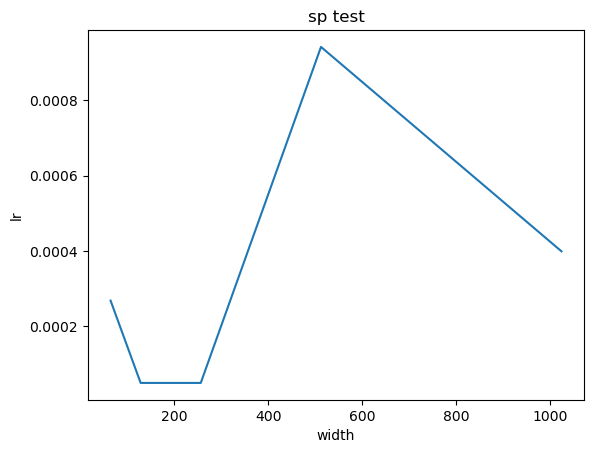

In [24]:
training_args = TrainingArguments(
    "test", evaluation_strategy="steps", eval_steps=500, disable_tqdm=True, remove_unused_columns=False, learning_rate=5e-5)

bests = {}
ts = time()
vary_nhead = False
widths = 2**np.arange(6, 11)
base_shape = make_bsh()
for mup in [True, False]:
    models = {width: get_model(width, base_shape=base_shape, mup=mup, vary_nhead=vary_nhead, n_labels=labels.num_classes) for width in widths}
    trainclass = MuTrainer if mup else Trainer
    for width, model in models.items():
        trainer = trainclass(
            model_init=model,
            args=training_args,
            data_collator=collate_fn,
            compute_metrics=compute_metrics,
            train_dataset=prepared_ds["train"],
            eval_dataset=prepared_ds["validation"],
            tokenizer=feature_extractor,
    #         optimizers=(AdamW,torch.optim.lr_scheduler.StepLR)
        )
        best = trainer.hyperparameter_search(
            backend="ray",
            n_trials=10, # number of trials
            name=f"{ts}_{'mup' if mup else 'sp'}_test_width_{width}",
            hp_space=lambda _: tune_config
        )
        bests[width] = best
    plt.title(f"{'mup' if mup else 'sp'} test")
    plt.plot(bests.keys(), [b.hyperparameters['learning_rate'] for b in bests.values()])
    plt.xlabel('width')
    plt.ylabel('lr')
   plt.show()